In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad

import jaxley as jx

import networkx as nx
import pandas as pd
import jax
from jax import vmap, jit

from jaxley.io.graph import to_graph, from_graph, make_jaxley_compatible
from jaxley.io.swc import swc_to_graph, swc_to_jaxley, read_swc
from jaxley.io.swc import swc_to_graph
from jaxley.io.graph import trace_branches, branch_e2n, branch_n2e, build_module_scaffold, make_jaxley_compatible

from neuron import h
from jaxley.channels import HH
import os

In [44]:
from neuron import h

def get_segment_xyzrL(section, comp_idx=None, loc=None, nseg=8):
    assert comp_idx is not None or loc is not None, "Either comp_idx or loc must be provided."
    assert not (comp_idx is not None and loc is not None), "Only one of comp_idx or loc can be provided."

    comp_len = 1/nseg
    loc = comp_len/2 + comp_idx*comp_len if loc is None else loc

    n3d = section.n3d()
    x3d = np.array([section.x3d(i) for i in range(n3d)])
    y3d = np.array([section.y3d(i) for i in range(n3d)])
    z3d = np.array([section.z3d(i) for i in range(n3d)])
    L = np.array([section.arc3d(i) for i in range(n3d)])  # Cumulative arc lengths
    r3d = np.array([section.diam3d(i)/2 for i in range(n3d)])
    if loc is None:
        return x3d, y3d, z3d, r3d
    else:
        total_length = L[-1]
        target_length = loc * total_length

        # Find segment containing target_length
        for i in range(1, n3d):
            if L[i] >= target_length:
                break
        else:
            i = n3d - 1

        # Interpolate between points i-1 and i
        L0, L1 = L[i-1], L[i]
        t = (target_length - L0) / (L1 - L0)
        x = x3d[i-1] + t * (x3d[i] - x3d[i-1])
        y = y3d[i-1] + t * (y3d[i] - y3d[i-1])
        z = z3d[i-1] + t * (z3d[i] - z3d[i-1])
        r = r3d[i-1] + t * (r3d[i] - r3d[i-1])
        return x, y, z, r, L[-1]/nseg


def jaxley2neuron_by_coords(cell, branch_loc=0.05, nseg=8):
    neuron_coords = {i: np.vstack(get_segment_xyzrL(sec, branch_loc, nseg=nseg))[:,:3].T for i, sec in enumerate(h.allsec())}
    neuron_coords = np.vstack([np.hstack([k*np.ones((v.shape[0], 1)), v]) for k,v in neuron_coords.items()])
    neuron_coords = pd.DataFrame(neuron_coords, columns=["branch_index", "x", "y", "z"])
    neuron_coords["branch_index"] = neuron_coords["branch_index"].astype(int)

    neuron_loc_xyz = neuron_coords.groupby("branch_index").mean()
    jaxley_loc_xyz = cell.branch("all").loc(branch_loc).show().set_index("branch_index")[["x", "y", "z"]]

    jaxley2neuron_inds = {}
    for i,xyz in enumerate(jaxley_loc_xyz.to_numpy()):
        d = np.sqrt(((neuron_loc_xyz - xyz)**2)).sum(axis=1)
        jaxley2neuron_inds[i] = d.argmin()
    return jaxley2neuron_inds


def jaxley2neuron_by_group(cell, branch_loc=0.05, nseg=8, num_apical=20, num_tuft=20, num_basal=10):
    y_apical = cell.apical.show().groupby("branch_index").mean()["y"].abs().sort_values()
    trunk_inds = y_apical.index[:num_apical].tolist()
    tuft_inds = y_apical.index[-num_tuft:].tolist()
    basal_inds = cell.basal.show()["branch_index"].unique()[:num_basal].tolist()

    jaxley2neuron = jaxley2neuron_by_coords(cell, loc=branch_loc, nseg=nseg)

    neuron_trunk_inds = [jaxley2neuron[i] for i in trunk_inds]
    neuron_tuft_inds = [jaxley2neuron[i] for i in tuft_inds]
    neuron_basal_inds = [jaxley2neuron[i] for i in basal_inds]

    neuron_inds = {"trunk": neuron_trunk_inds, "tuft": neuron_tuft_inds, "basal": neuron_basal_inds}
    jaxley_inds = {"trunk": trunk_inds, "tuft": tuft_inds, "basal": basal_inds}
    return neuron_inds, jaxley_inds

def match_stim_loc(jx_cell, neuron_sec, loc=0.05, nseg=8):
    stim_coords = get_segment_xyzrL(neuron_sec, loc=loc, nseg=nseg)[:,:3]
    stim_idx = ((jx_cell.nodes[["x", "y", "z"]]-stim_coords)**2).sum(axis=1).argmin()
    return stim_idx

def import_neuron_morph(fname, nseg=8):
    _ = h.load_file("stdlib.hoc")
    _ = h.load_file("import3d.hoc")
    nseg = 8

    ##################### NEURON ##################
    for sec in h.allsec():
        h.delete_section(sec=sec)

    cell = h.Import3d_SWC_read()
    cell.input(fname)
    i3d = h.Import3d_GUI(cell, False)
    i3d.instantiate(None)

    for sec in h.allsec():
        sec.nseg = nseg
    return cell

_ = h.load_file("stdlib.hoc")
_ = h.load_file("import3d.hoc")

def test_swc_voltages(jx_cell):
    """Check if voltages of SWC recording match.

    To match the branch indices between NEURON and jaxley, we rely on comparing the
    length of the branches.

    It tests whether, on average over time and recordings, the voltage is off by less
    than 1.5 mV.
    """
    fname = os.path.join("../tests/swc_files/", "morph.swc")  # n120

    i_delay = 2.0
    i_dur = 5.0
    i_amp = 0.25
    t_max = 20.0
    dt = 0.025

    nseg_per_branch = 8

    ##################### NEURON ##################
    for sec in h.allsec():
        h.delete_section(sec=sec)

    cell = h.Import3d_SWC_read()
    cell.input(fname)
    i3d = h.Import3d_GUI(cell, False)
    i3d.instantiate(None)

    for sec in h.allsec():
        sec.nseg = nseg_per_branch

    ####################### jaxley ##################
    jx_cell.insert(HH())

    branch_loc = 0.05
    neuron_inds, jaxley_inds = jaxley2neuron_by_group(jx_cell, loc=branch_loc)
    trunk_inds, tuft_inds, basal_inds = [jaxley_inds[key] for key in ["trunk", "tuft", "basal", "stim"]]
    neuron_trunk_inds, neuron_tuft_inds, neuron_basal_inds = [neuron_inds[key] for key in ["trunk", "tuft", "basal"]]
    
    stim_loc = 0.1
    stim_idx = match_stim_loc(jx_cell, h.soma[0], loc=stim_loc)

    jx_cell.set("axial_resistivity", 1_000.0)
    jx_cell.set("v", -62.0)
    jx_cell.set("HH_m", 0.074901)
    jx_cell.set("HH_h", 0.4889)
    jx_cell.set("HH_n", 0.3644787)

    jx_cell.branch.comp(stim_idx).stimulate(
        jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
    )
    for i in trunk_inds + tuft_inds + basal_inds:
        jx_cell.branch(i).loc(branch_loc).record()

    voltages_jaxley = jx.integrate(jx_cell, delta_t=dt)

    ################### NEURON #################
    stim = h.IClamp(h.soma[0](stim_loc))
    stim.delay = i_delay
    stim.dur = i_dur
    stim.amp = i_amp

    counter = 0
    voltage_recs = {}

    for r in neuron_trunk_inds:
        for i, sec in enumerate(h.allsec()):
            if i == r:
                v = h.Vector()
                v.record(sec(branch_loc)._ref_v)
                voltage_recs[f"v{counter}"] = v
                counter += 1

    for r in neuron_tuft_inds:
        for i, sec in enumerate(h.allsec()):
            if i == r:
                v = h.Vector()
                v.record(sec(branch_loc)._ref_v)
                voltage_recs[f"v{counter}"] = v
                counter += 1

    for r in neuron_basal_inds:
        for i, sec in enumerate(h.allsec()):
            if i == r:
                v = h.Vector()
                v.record(sec(branch_loc)._ref_v)
                voltage_recs[f"v{counter}"] = v
                counter += 1

    for sec in h.allsec():
        sec.insert("hh")
        sec.Ra = 1_000.0

        sec.gnabar_hh = 0.120  # S/cm2
        sec.gkbar_hh = 0.036  # S/cm2
        sec.gl_hh = 0.0003  # S/cm2
        sec.ena = 50  # mV
        sec.ek = -77.0  # mV
        sec.el_hh = -54.3  # mV

    h.dt = dt
    tstop = t_max
    v_init = -62.0

    def initialize():
        h.finitialize(v_init)
        h.fcurrent()

    def integrate():
        while h.t < tstop:
            h.fadvance()

    initialize()
    integrate()
    voltages_neuron = np.asarray([voltage_recs[key] for key in voltage_recs])

    ####################### check ################
    errors = np.mean(np.abs(voltages_jaxley - voltages_neuron), axis=1)

    assert all(errors < 1.5), "voltages do not match."
    return voltages_jaxley, voltages_neuron

In [128]:
def test_graph_swc_tracer():
    nseg = 8
    fname = os.path.join("../tests/swc_files/", "morph.swc")  # n120
    
    graph = swc_to_graph(fname)
    graph = make_jaxley_compatible(graph, nseg=nseg, max_branch_len=2000, ignore_swc_trace_errors=False)
    cell = from_graph(graph, nseg=nseg, max_branch_len=2000)
    neuron_cell = import_neuron_morph(fname, nseg=nseg)
    
    # remove root branch
    jaxley_comps = cell.nodes[cell.nodes["branch_index"] != 0].reset_index(drop=True)
    jaxley_comps["branch_index"] -= 1

    jx_branch_lens = jaxley_comps.groupby("branch_index")["length"].sum().to_numpy()

    # match by branch lengths
    neuron_xyzd = [np.array(s.psection()["morphology"]["pts3d"]) for s in h.allsec()]
    neuron_branch_lens = np.array([np.sqrt((np.diff(n[:,:3], axis=0)**2).sum(axis=1)).sum() for n in neuron_xyzd])
    neuron_inds = np.argsort(neuron_branch_lens)
    jx_inds = np.argsort(jx_branch_lens)

    errors = pd.DataFrame(columns=["idx_NEURON", "idx_Jaxley", "dxyz", "dl", "dr"])
    for k in range(len(neuron_inds)):
        neuron_comp_k = np.array([get_segment_xyzrL(list(h.allsec())[neuron_inds[k]], comp_idx=i) for i in range(nseg)])
        jx_comp_k = jaxley_comps[jaxley_comps["branch_index"] == jx_inds[k]][["x", "y", "z", "radius", "length"]].to_numpy()
        dxyz = (((neuron_comp_k[:,:3] - jx_comp_k[:,:3])**2).sum(axis=1)**0.5).max()
        dl = abs(neuron_comp_k[:,4] - jx_comp_k[:,4]).max()
        dr = abs(neuron_comp_k[:,3] - jx_comp_k[:,3]).max()
        errors.loc[k] = [neuron_inds[k], jx_inds[k], dxyz, dl, dr]
    error_exceeds_thresh = errors[['dxyz', 'dl', 'dr']] > 0.001

    # allow one error, see https://github.com/jaxleyverse/jaxley/issues/140
    assert len(errors['dxyz'][error_exceeds_thresh['dxyz']]) <= 1, "SWC tracers do not match."

test_graph_swc_tracer()

/tmp/ipykernel_1519238/1312587570.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  jx_xyzrl = jaxley_comps.groupby("branch_index").apply(lambda x: x.iloc[comp_idx])[["x", "y", "z", "radius", "length"]].to_numpy()


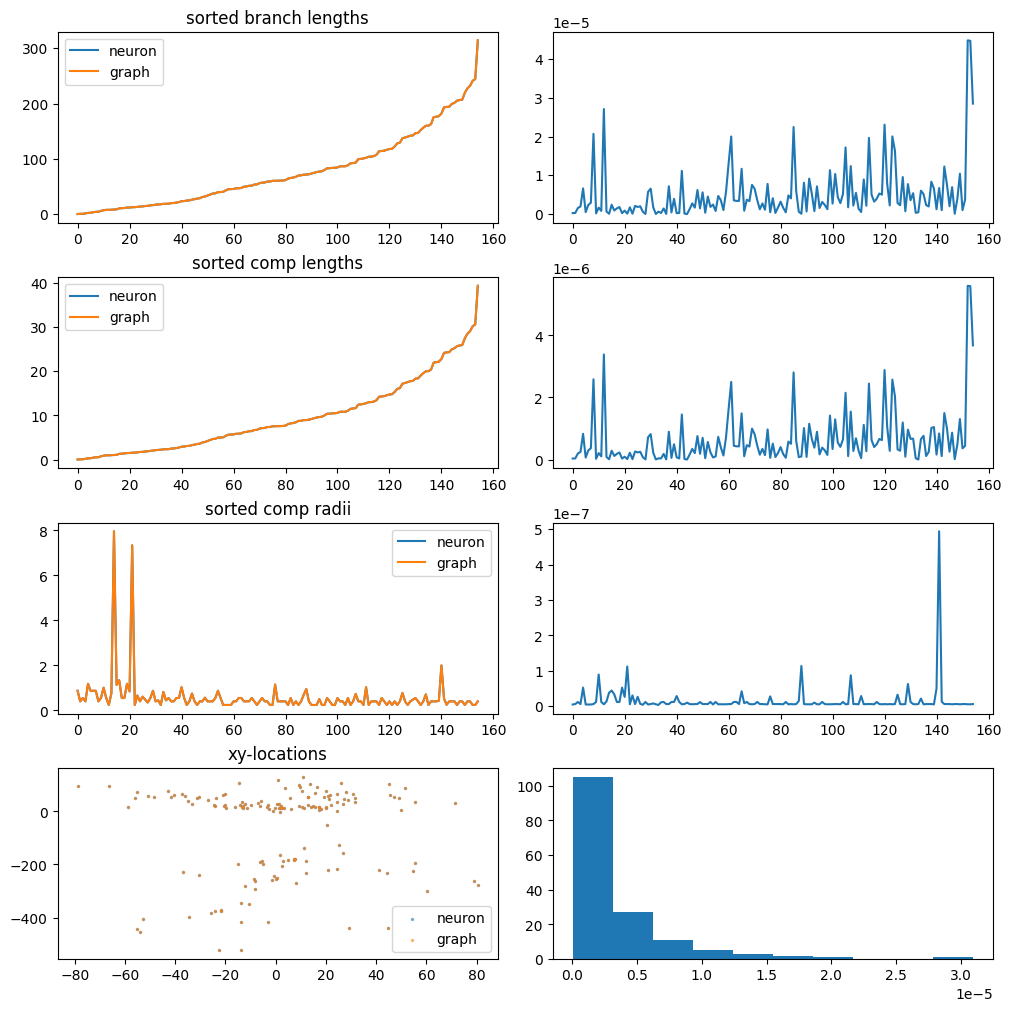

In [48]:
from jaxley.io.graph import add_edge_lens, split_branches, find_swc_trace_errors, simulate_swc_trace_errors, soma_idxs, branch_e2n, v_interp

nseg = 8
fname = os.path.join("../tests/swc_files/", "morph.swc")  # n120
graph = swc_to_graph(fname)
graph = make_jaxley_compatible(graph, nseg=nseg, max_branch_len=2000, ignore_swc_trace_errors=False)
cell = from_graph(graph, nseg=nseg, max_branch_len=2000)

# graph = add_edge_lens(graph)  # add edge lengths to graph just in case
# branches = trace_branches(graph, source_node=source_node)

# breaks = find_swc_trace_errors(graph)
# branches = simulate_swc_trace_errors(branches, breaks)

comp_idx = 2
comp_len = 1/nseg
branch_loc = comp_len/2 + comp_idx*comp_len

jaxley_comps = cell.nodes[cell.nodes["branch_index"] != 0].reset_index(drop=True)
jaxley_comps["branch_index"] -= 1
jx_branch_lens = jaxley_comps.groupby("branch_index")["length"].sum().to_numpy()

neuron_cell = import_neuron_morph(fname)
neuron_xyzd = [np.array(s.psection()["morphology"]["pts3d"]) for s in h.allsec()]
neuron_branch_lens = np.array([np.sqrt((np.diff(n[:,:3], axis=0)**2).sum(axis=1)).sum() for n in neuron_xyzd])

neuron_inds = np.argsort(neuron_branch_lens)
jx_inds = np.argsort(jx_branch_lens)
wo_error = np.where(abs(neuron_branch_lens[neuron_inds] - jx_branch_lens[jx_inds]) < 1)[0]
neuron_inds = neuron_inds[wo_error]
jx_inds = jx_inds[wo_error]

neuron_xyzrl = np.array([get_segment_xyzrL(s, loc=branch_loc, nseg=nseg) for s in h.allsec()])
jx_xyzrl = jaxley_comps.groupby("branch_index").apply(lambda x: x.iloc[comp_idx])[["x", "y", "z", "radius", "length"]].to_numpy()

fname = os.path.join("../tests/swc_files/", "morph.swc")  # n120

fig, ax = plt.subplots(4, 2, figsize=(10, 10), layout="constrained")

ax[0,0].plot(neuron_branch_lens[neuron_inds], label="neuron")
ax[0,0].plot(jx_branch_lens[jx_inds], label="graph")
ax[0,1].plot(abs(neuron_branch_lens[neuron_inds] - jx_branch_lens[jx_inds]), label="diff")
ax[0,0].set_title("sorted branch lengths")
ax[0,0].legend()

k = 4
ax[1,0].plot(neuron_xyzrl[neuron_inds][:,k], label="neuron")
ax[1,0].plot(jx_xyzrl[jx_inds][:,k], label="graph")
ax[1,1].plot(abs(neuron_xyzrl[neuron_inds][:,k] - jx_xyzrl[jx_inds][:,k]), label="diff")
ax[1,0].set_title("sorted comp lengths")
ax[1,0].legend()

k = 3
ax[2,0].plot(neuron_xyzrl[neuron_inds][:,k], label="neuron")
ax[2,0].plot(jx_xyzrl[jx_inds][:,k], label="graph")
ax[2,1].plot(abs(neuron_xyzrl[neuron_inds][:,k] - jx_xyzrl[jx_inds][:,k]), label="diff")
ax[2,0].set_title("sorted comp radii")
ax[2,0].legend()

ax[3,0].scatter(neuron_xyzrl[neuron_inds][:,0], neuron_xyzrl[neuron_inds][:,1], alpha=0.5, s=2, label="neuron")
ax[3,0].scatter(jx_xyzrl[jx_inds][:,0], jx_xyzrl[jx_inds][:,1], alpha=0.5, s=2, label="graph")
dx = ((neuron_xyzrl[neuron_inds][:,:3] - jx_xyzrl[jx_inds][:,:3])**2).sum(axis=1)**0.5
ax[3,1].hist(dx, label="diff")
ax[3,0].set_title("xy-locations")
ax[3,0].legend()
plt.show()

In [727]:
for k in range(len(neuron_inds)):
    neuron_comp_k = np.array([get_segment_xyzrL(list(h.allsec())[neuron_inds[k]], (1/nseg)/2 + i/nseg) for i in range(nseg)])
    jx_comp_k = jaxley_comps[jaxley_comps["branch_index"] == jx_inds[k]][["x", "y", "z", "radius", "length"]].to_numpy()
    dx = (((neuron_comp_k[:,:3] - jx_comp_k[:,:3])**2).sum(axis=1)**0.5).mean()
    dl = abs(neuron_comp_k[:,4] - jx_comp_k[:,4]).mean()
    dr = abs(neuron_comp_k[:,3] - jx_comp_k[:,3]).mean()
    print(f"compartment {k}: dx = {dx:.2f}, dl = {dl:.2f}, dr = {dr:.2f}")

compartment 0: dx = 0.00, dl = 0.00, dr = 0.00
compartment 1: dx = 0.00, dl = 0.00, dr = 0.00
compartment 2: dx = 0.00, dl = 0.00, dr = 0.00
compartment 3: dx = 0.00, dl = 0.00, dr = 0.00
compartment 4: dx = 0.00, dl = 0.00, dr = 0.00
compartment 5: dx = 0.00, dl = 0.00, dr = 0.00
compartment 6: dx = 0.00, dl = 0.00, dr = 0.00
compartment 7: dx = 0.00, dl = 0.00, dr = 0.00
compartment 8: dx = 0.00, dl = 0.00, dr = 0.00
compartment 9: dx = 0.00, dl = 0.00, dr = 0.00
compartment 10: dx = 0.00, dl = 0.00, dr = 0.00
compartment 11: dx = 0.00, dl = 0.00, dr = 0.00
compartment 12: dx = 0.00, dl = 0.00, dr = 0.00
compartment 13: dx = 0.00, dl = 0.00, dr = 0.00
compartment 14: dx = 0.00, dl = 0.00, dr = 0.00
compartment 15: dx = 0.00, dl = 0.00, dr = 0.00
compartment 16: dx = 0.00, dl = 0.00, dr = 0.00
compartment 17: dx = 0.00, dl = 0.00, dr = 0.00
compartment 18: dx = 0.00, dl = 0.00, dr = 0.00
compartment 19: dx = 0.00, dl = 0.00, dr = 0.00
compartment 20: dx = 0.00, dl = 0.00, dr = 0.00
co

In [25]:
fname = os.path.join("../tests/swc_files/", "morph.swc")  # n120
graph = swc_to_graph(fname)
nx_cell = from_graph(graph, nseg=8, max_branch_len=2000.0)

In [630]:
fname = os.path.join("../tests/swc_files/", "morph.swc")  # n120

graph = swc_to_graph(fname)
graph = make_jaxley_compatible_v2(graph, max_branch_len=2000.0, nseg=8, source_node=0)
nx_cell = from_graph(graph, nseg=8, max_branch_len=2000.0)
# nx_cell.compute_xyz(); nx_cell._update_nodes_with_xyz() #-> changes xyzs and makes less similar to NEURON and more similar to current jaxley!

# swc_cell = jx.read_swc(fname, 8, max_branch_len=2000.0, assign_groups=True)
# swc_cell._update_nodes_with_xyz()

neuron_cell = import_neuron_morph(fname)

In [13]:
# graph = swc_to_graph(fname)
# cell_v1 = from_graph(graph, nseg=8, max_branch_len=2000.0)

graph = swc_to_graph(fname)
graph = make_jaxley_compatible_v2(graph, max_branch_len=2000)
cell_v2 = from_graph(graph, nseg=8, max_branch_len=2000)

# cell_swc = read_swc(fname, 8, max_branch_len=2000.0, assign_groups=True)
# cell_swc._update_nodes_with_xyz()


# v_swc, v_swc_neuron = test_swc_voltages(cell_swc)
v_nx, v_nx_neuron = test_swc_voltages(cell_v2)

Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.r

MSEs between networkX and NEURON voltages [1.04713083 1.05762205 1.12190617 1.12256981 1.10002585 1.11516644
 1.14133652 1.06901444 1.07062674 1.23506127 1.2488945  1.05729204
 1.31578322 1.10680595 0.84590106 1.02711285 0.96237384 1.0017698
 0.82199011 0.76980736 0.826342   0.86485781 0.80588585 0.97928768
 0.77268776 0.96853645 0.77838237]
MSEs between jaxley_swc_reader and NEURON voltages [0.99074595 0.99798788 1.06303194 1.06644151 1.04075219 1.08479116
 1.08351713 0.949176   1.20691056 1.17982389 1.19336607 1.00193021
 1.06711586 1.05206764 0.63350792 0.96918593 0.90271575 0.9424342
 0.76555555 0.71062625 0.77389985 0.81035832 0.75040486 0.92461516
 0.72069685 0.91403832 0.7240964 ]


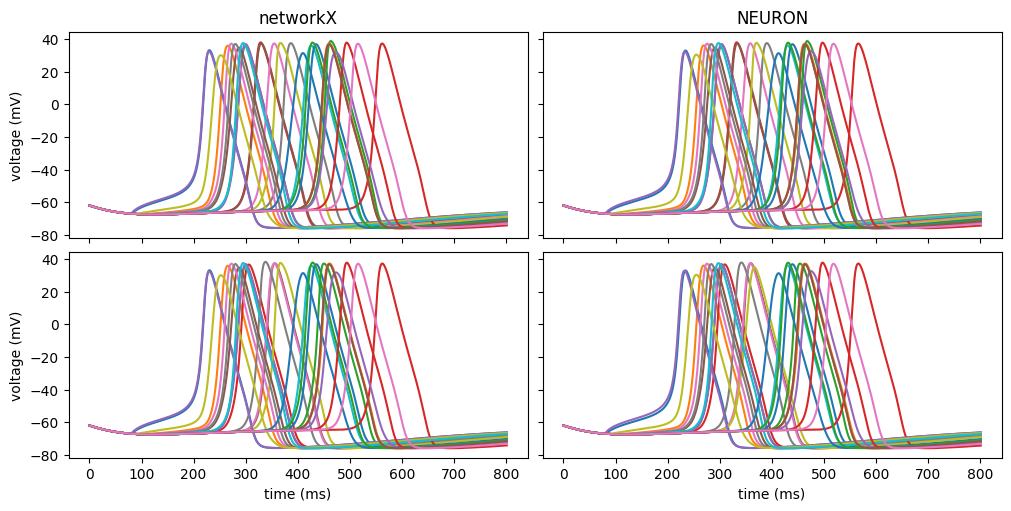

In [636]:
print("MSEs between networkX and NEURON voltages", np.mean(np.abs(v_nx - v_nx_neuron), axis=1)) 
# print("MSEs between jaxley_swc_reader and NEURON voltages", np.mean(np.abs(v_swc - v_swc_neuron), axis=1)) 

# plot the different voltages
fig, ax = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=True, layout="constrained")
ax[0,0].plot(v_nx.T)
ax[0,1].plot(v_nx_neuron.T)
# ax[1,0].plot(v_swc.T)
# ax[1,1].plot(v_swc_neuron.T)


ax[0,0].set_title("networkX")
ax[0,1].set_title("NEURON")
ax[0,0].set_ylabel("voltage (mV)")
ax[1,0].set_ylabel("voltage (mV)")
ax[1,1].set_xlabel("time (ms)")
ax[1,0].set_xlabel("time (ms)")

plt.show()